In [1]:
#Program: creditCardFraudDetection.ipynb
#Purpose: Run exploratory data analysis on dataset from Kaggle (functions this time) then attempt basic machine learning
#Dataset and Prompt (+ examples): https://www.kaggle.com/mlg-ulb/creditcardfraud
#Tutorial: https://www.thepythoncode.com/article/credit-card-fraud-detection-using-sklearn-in-python
#Date: 6 June 2023

In [2]:
#Import libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split #test split
from sklearn.model_selection import StratifiedKFold #Cross validation framework
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV #Cross validation framework
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score #Metrics
from sklearn.linear_model import LogisticRegression #Classifier
from sklearn.svm import SVC #Classifier
from sklearn.neighbors import KNeighborsClassifier #Classifier
from sklearn.tree import DecisionTreeClassifier #Classifier
from sklearn.ensemble import RandomForestClassifier #Classifier
from imblearn.pipeline import make_pipeline ## Create a Pipeline using the provided estimators .
from imblearn.under_sampling import NearMiss  ## perform Under-sampling  based on NearMiss methods. 
from imblearn.over_sampling import SMOTE  ## PerformOver-sampling class that uses SMOTE. 
import matplotlib.pyplot as plt # plotting
import matplotlib.gridspec as gridspec #gridspec
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #my personal favorite visualization library

In [3]:
#Read csv file and create csv
nRowsRead = None
df1 = pd.read_csv(r'C:\Users\brett\Downloads\archive (1)\creditcard.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'creditcard.csv'

In [4]:
#Correlation matrix
#Source: see Kaggle dataset link
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [5]:
#Scatter matrix with histograms on diagonal
#Source: see Kaggle dataset link
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist') #Changed to histograms because I prefer over kde
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [6]:
#Description text (personal code)
with open('describe_credit_card_data.txt', 'a') as describeFile:
    describeFile.truncate(0)
    columnsList = list(df1.columns)
    for column in columnsList:
        describeColumn = df1[column].describe()
        stringColumn = str(describeColumn)
        describeFile.write(stringColumn)

C:\Users\brett\AppData\Local\Temp\ipykernel_10216\3027074042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


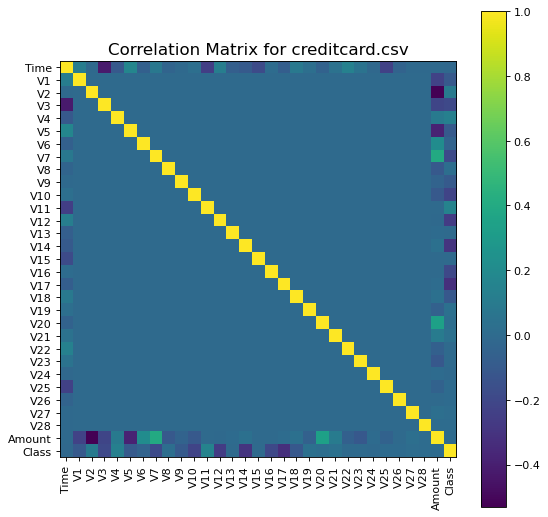

C:\Users\brett\AppData\Local\Temp\ipykernel_10216\2350213232.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


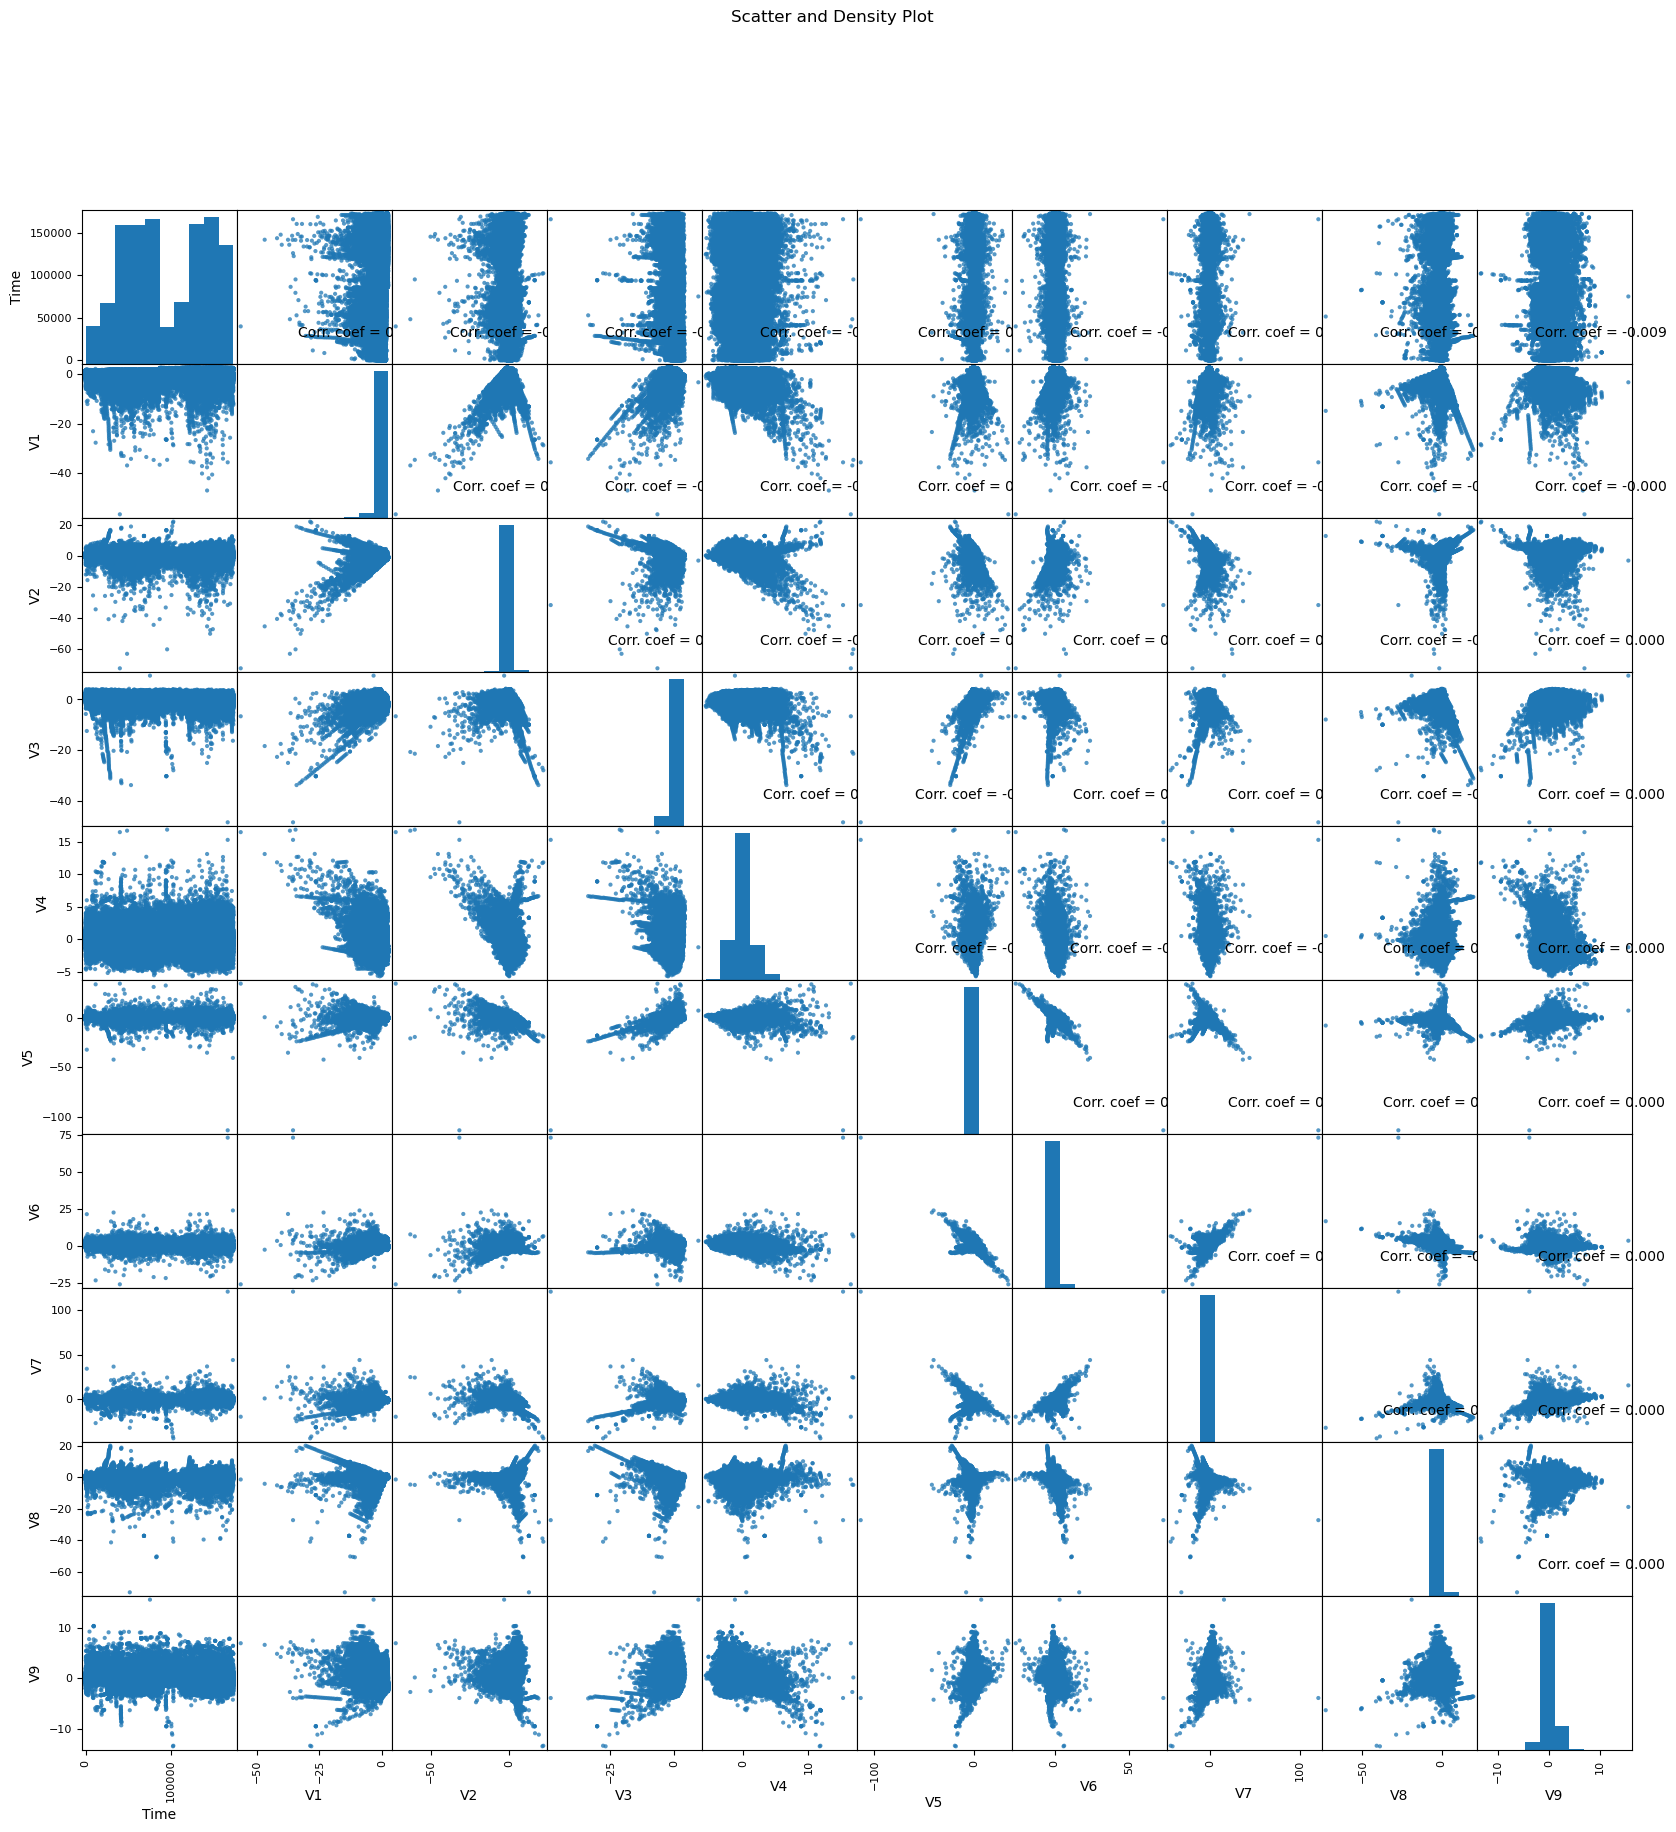

In [7]:
#Call correlation matrix and scatter matrix
plotCorrelationMatrix(df1, 8)
plotScatterMatrix(df1,20,10)

In [8]:
#Show fraud cases, valild cases, and proportion (code from tutorial but I refuse to use a pie chart)
print('Fraudulent Cases: ' + str(len(df1[df1['Class'] == 1])))
print('Fraudulent Cases: ' + str(len(df1[df1['Class'] == 0])))
print('Proportion of Fraudulent Cases: ' + str(len(df1[df1['Class'] == 1])/df1.shape[0]))

Fraudulent Cases: 492
Fraudulent Cases: 284315
Proportion of Fraudulent Cases: 0.001727485630620034


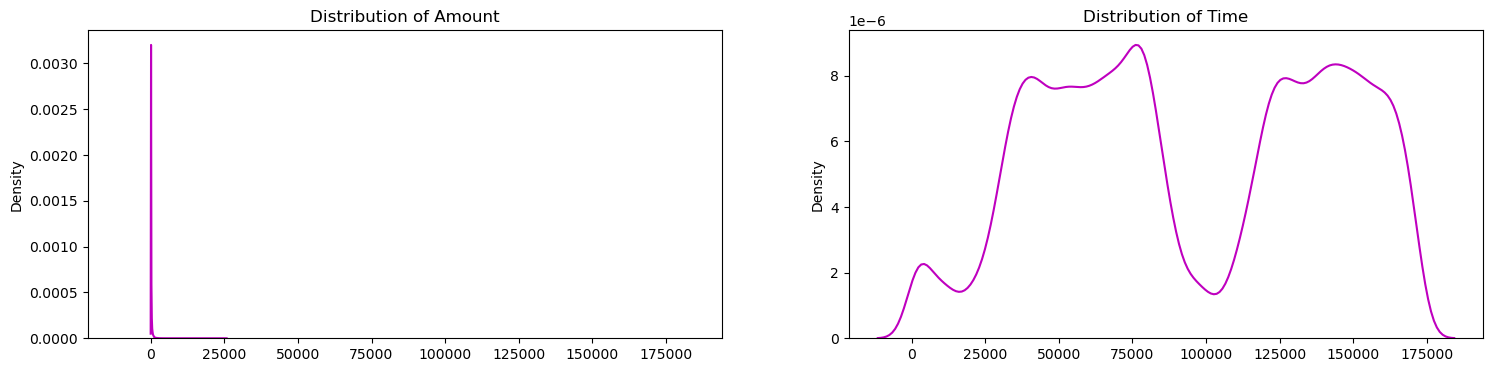

In [9]:
#Use seaborn to plot distribution of amount and distribution of time

#Close earlier figures
plt.close()

#Create two subplots with control and sharing x values
f, axes = plt.subplots(1, 2, figsize=(18,4), sharex=True)

#Retrieve values for amount and time from dataframe
amountValue = df1['Amount'].values
timeValue = df1['Time'].values

#Plot distribution of these variables use kde in displot command from seaborn
sns.kdeplot(amountValue, color='m', ax=axes[0]).set_title('Distribution of Amount')
sns.kdeplot(timeValue, color='m', ax=axes[1]).set_title('Distribution of Time')

plt.show()

In [10]:
#Check average amount in fraud vs valid transactions
print('Average Amount in Fraudulent Transaction: ' + str(df1[df1['Class']==1]['Amount'].mean()))
print('Average Amount in Valid Transaction: ' + str(df1[df1['Class']==0]['Amount'].mean()))

Average Amount in Fraudulent Transaction: 122.21132113821139
Average Amount in Valid Transaction: 88.29102242231328


In [11]:
#Further analyze the significant feature of the  amount
print('Amount Description:')
display(df1['Amount'].describe())

Amount Description:


count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [12]:
#Analyze fraudulent case type from significant feature of the amount
print('Amount and Fraud Description:')
display(df1[df1['Class']==1]['Amount'].describe())

Amount and Fraud Description:


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
#Analyze valid case type from significant feature of the 
print('Amount and Valid Description:')
display(df1[df1['Class']==0]['Amount'].describe())

Amount and Valid Description:


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

C:\Users\brett\AppData\Local\Temp\ipykernel_10216\3961844176.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax = plt.subplots()


<Figure size 1200x12000 with 0 Axes>

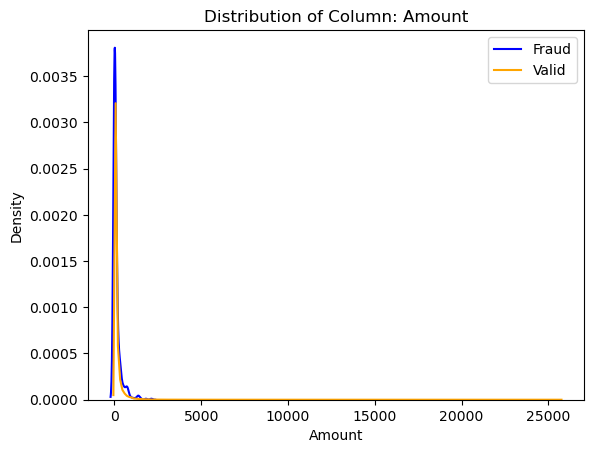

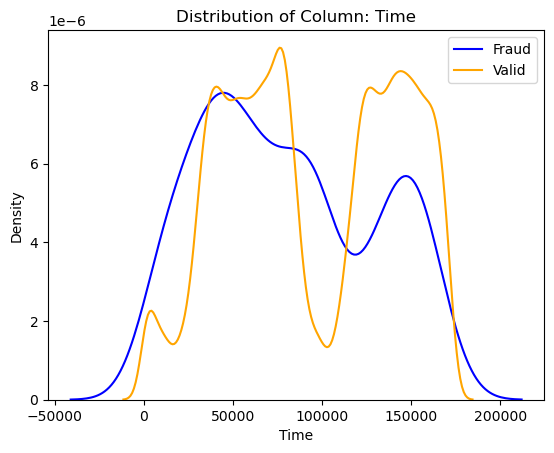

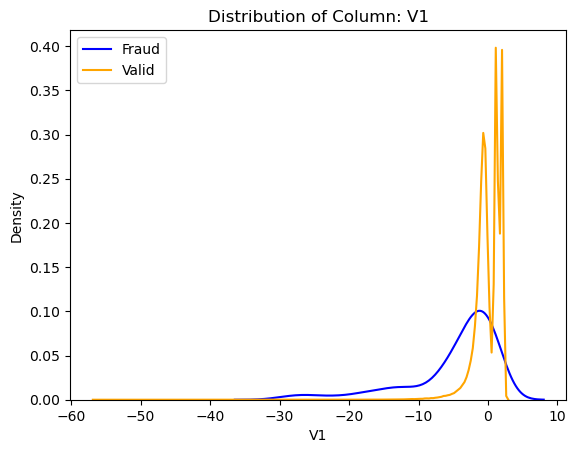

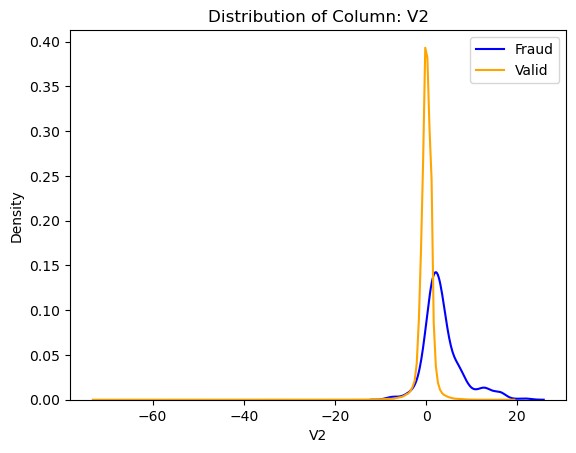

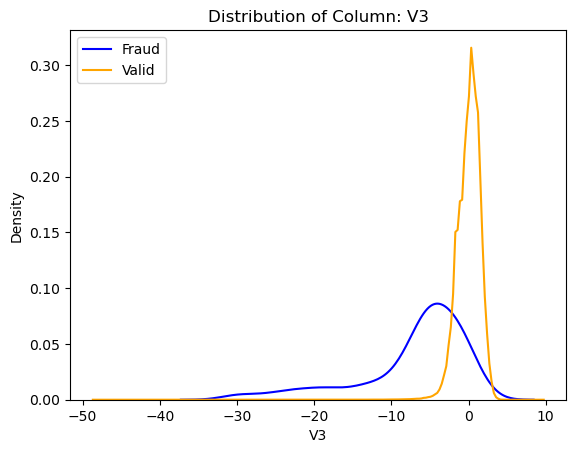

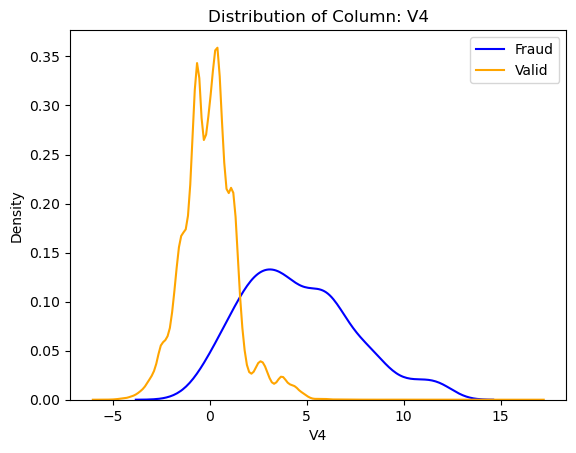

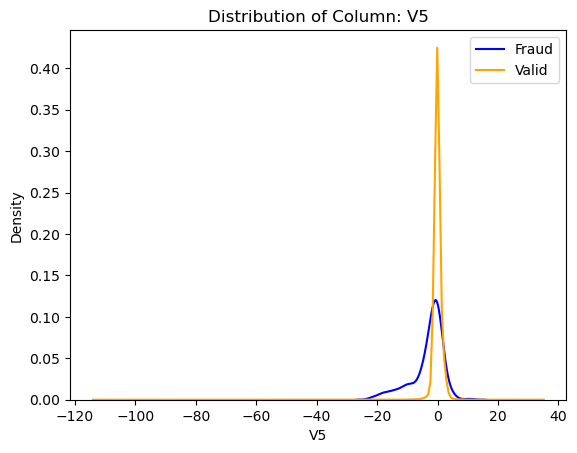

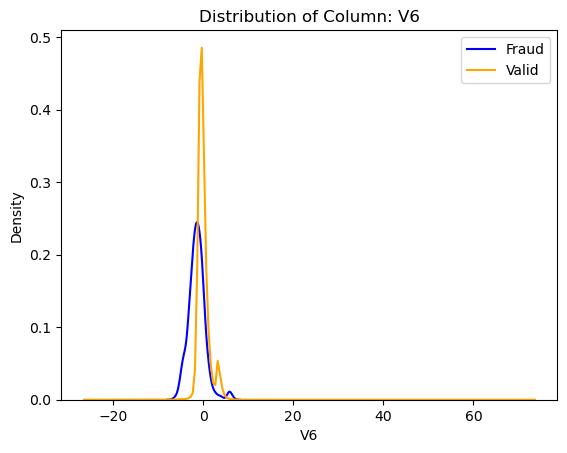

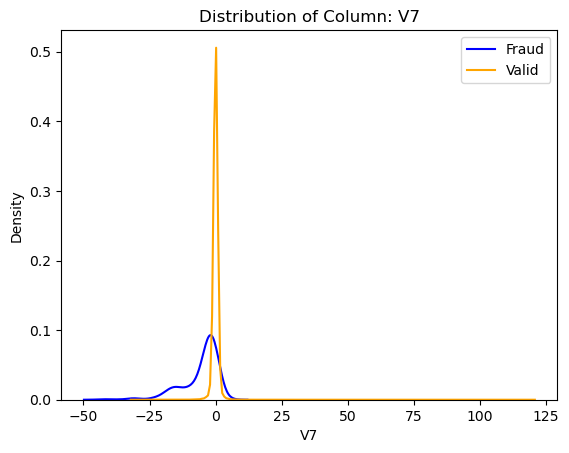

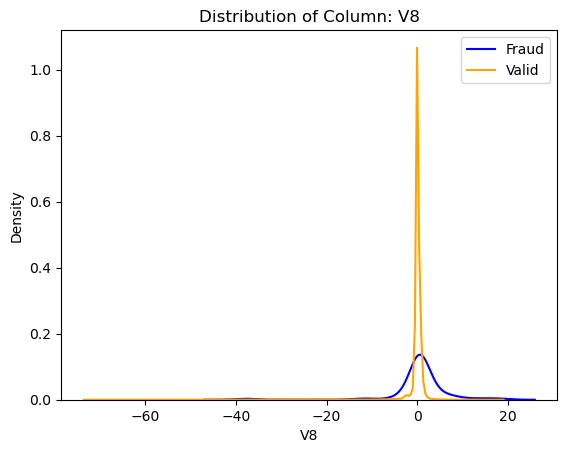

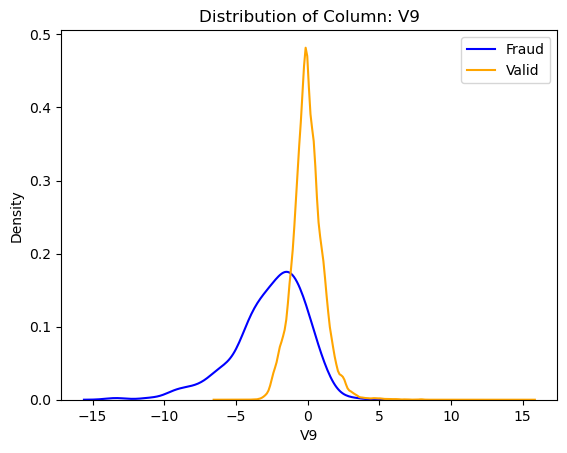

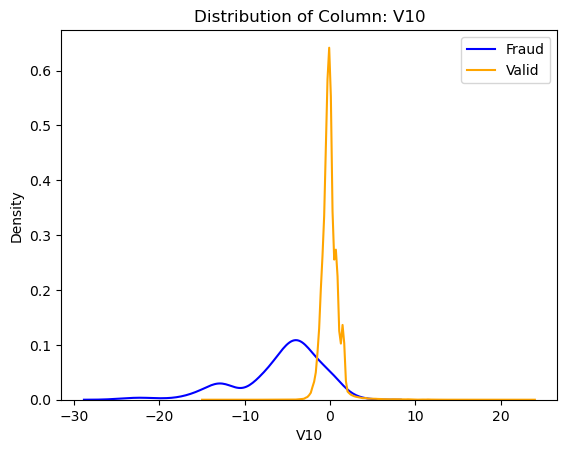

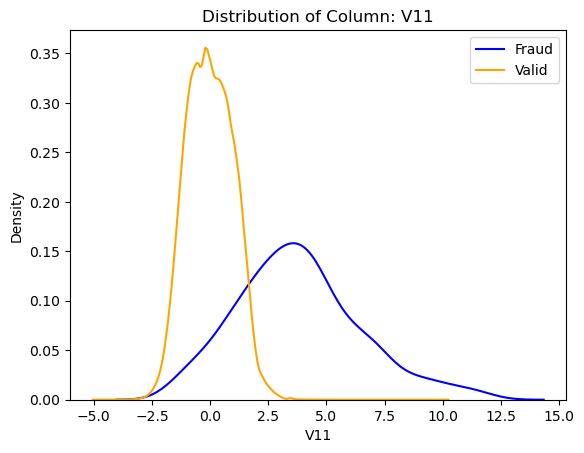

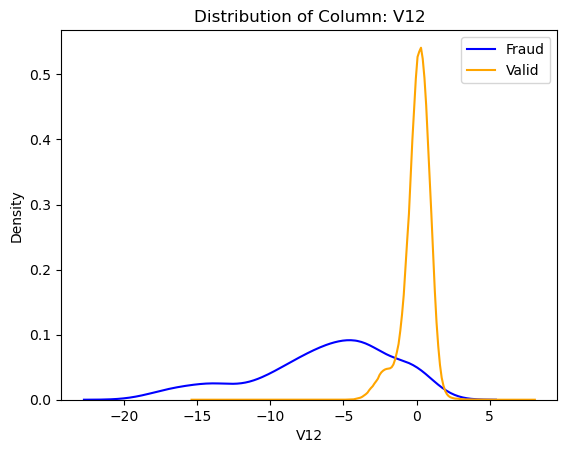

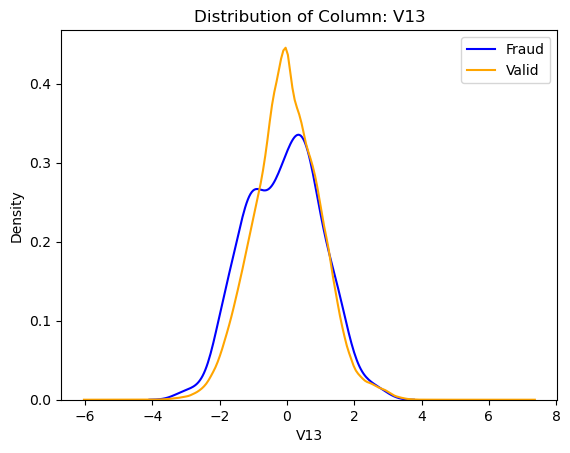

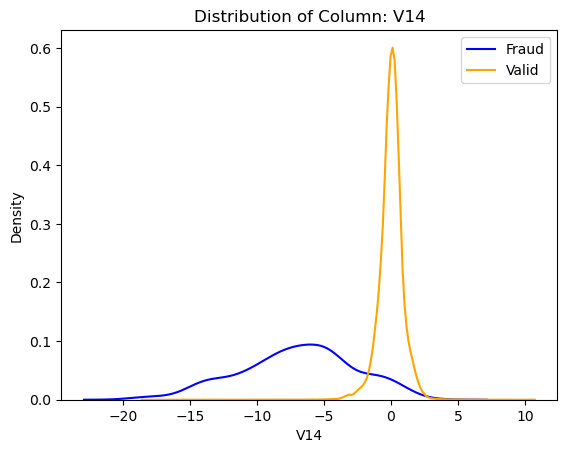

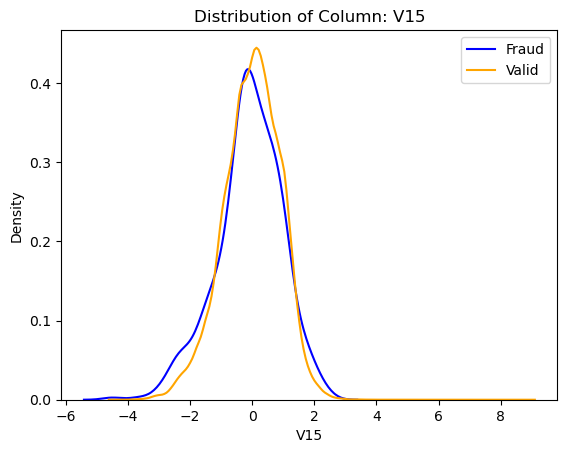

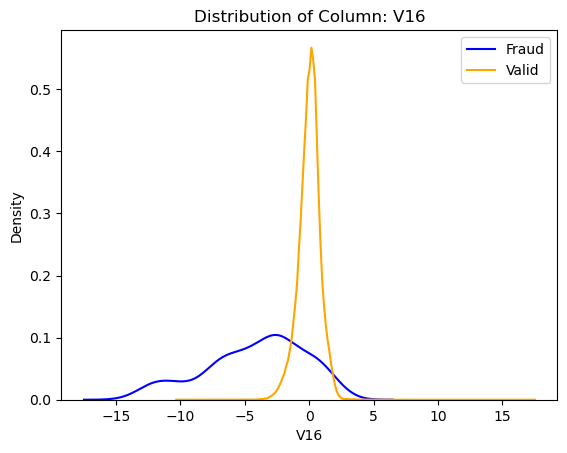

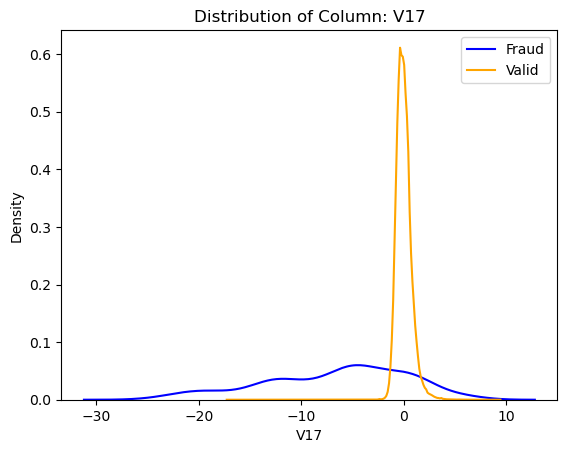

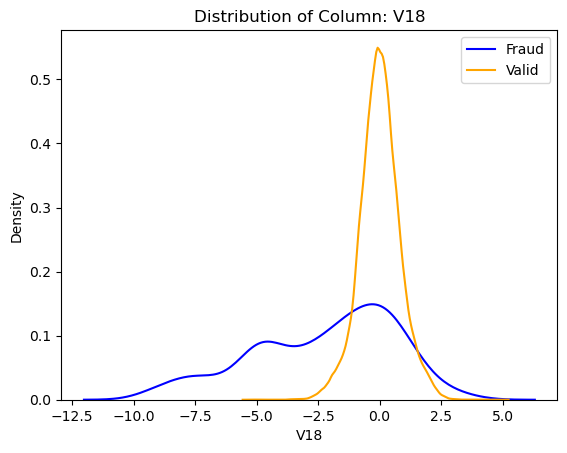

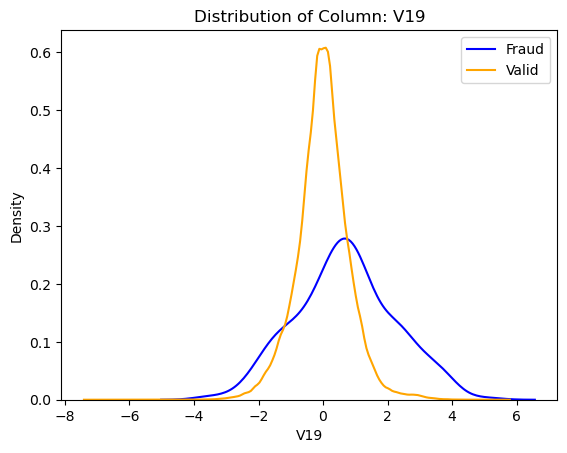

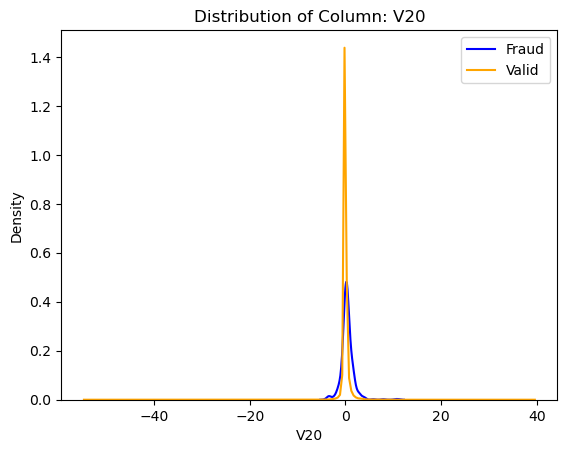

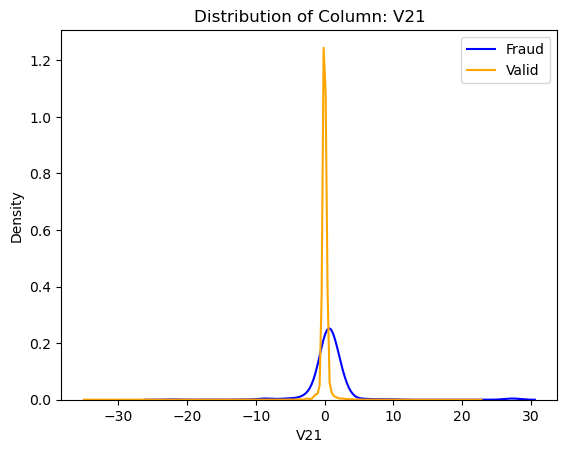

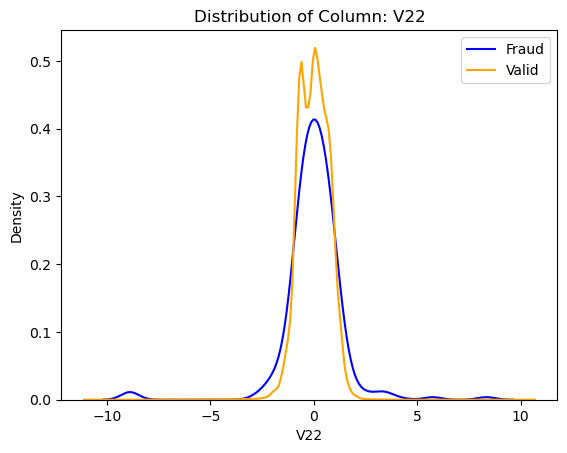

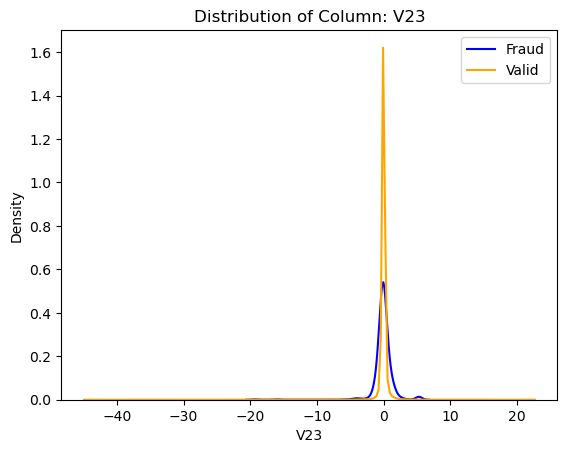

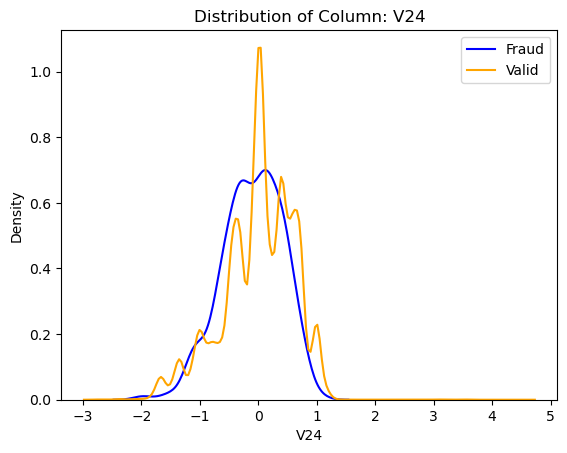

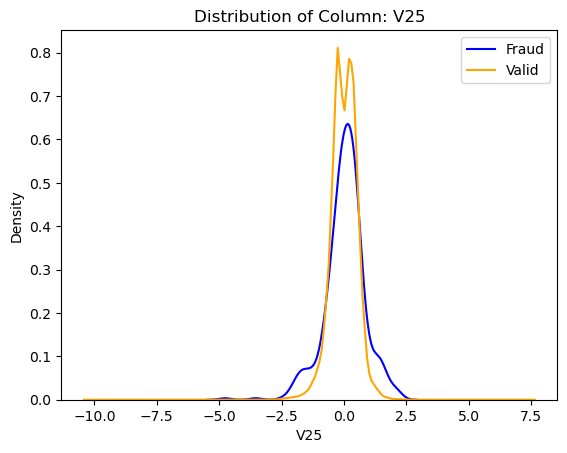

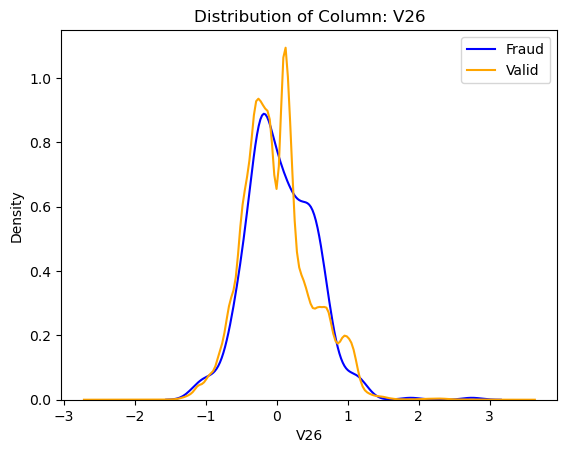

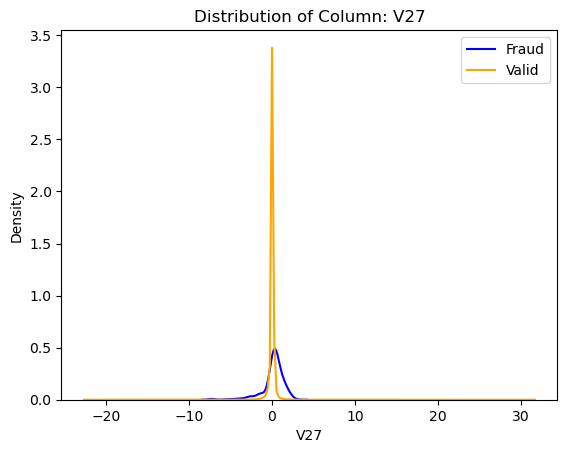

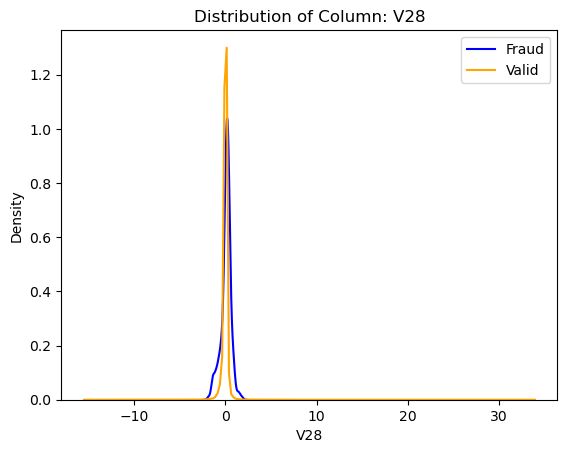

In [14]:
#Breakdown of values based on individual columns
#Do not understand the math behind this yet, believe it falls under cluster detection
#Further source for examples: https://medium.com/analytics-vidhya/credit-card-fraud-detection-an-exercise-in-class-imbalance-c4b8fd5ba603

#Close earlier figures
plt.close()

#Reorder the columns Amount, Time then rest
dataPlot = df1.copy()
amountColumn = dataPlot['Amount']
dataPlot.drop(labels=['Amount'], axis=1, inplace=True)
dataPlot.insert(0, 'Amount', amountColumn)

#Plot the distributions of the features
columns = dataPlot.iloc[:,0:30].columns
plt.figure(figsize=(12,30*4))
grids = gridspec.GridSpec(30, 1)
for grid, index in enumerate(dataPlot[columns]):
    ax = plt.subplots()
    sns.kdeplot(dataPlot[index][dataPlot.Class == 1], color='b')
    sns.kdeplot(dataPlot[index][dataPlot.Class == 0], color='orange').set_title('Distribution of Column: ' + str(index))
    plt.legend(labels=['Fraud', 'Valid'])
plt.show()

In [15]:
#Finished EDA, now working on Data Preparation 

#Check for null values
print(df1.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [16]:
#Research into scalers: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02#:~:text=types%20of%20scales-,RobustScaler,scale%20to%20the%20other%20features.
scaler = RobustScaler().fit(df1[['Time', 'Amount']])
df1[['Time', 'Amount']] = scaler.transform(df1[['Time', 'Amount']])

In [17]:
#Research into data splitting: https://www.techtarget.com/searchenterpriseai/definition/data-splitting
#Separate responses and features (Undersampling before cross-validation will lead to overfitting)
y = df1['Class']
x = df1.iloc[:,0:30]

#sklearn fit
X_train, X_test, y_train, y_test = train_test_split( 
        x, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 30), (56962, 30), (227845,), (56962,))

In [18]:
#Cross validation framework
kf = StratifiedKFold(n_splits=5, random_state = None, shuffle = False)

In [19]:
#End of Data Preparation, onto the Building and Training of the Model

#Run RandomForestClassifier and check performance
#Research into RandomForestClassifier: https://towardsdatascience.com/understanding-random-forest-58381e0602d2

#Fit and predict
rfc = RandomForestClassifier() 
rfc.fit(X_train, y_train) 
y_pred = rfc.predict(X_test)

#Print out accuracy, precision, recall, and F1 score
print("The accuracy is", accuracy_score(y_test, y_pred)) 
print("The precision is", precision_score(y_test, y_pred))
print("The recall is", recall_score(y_test, y_pred))
print("The F1 score is", f1_score(y_test, y_pred))

#From this, it can be assumed that accuracy is not the proper metric for the problem

The accuracy is 0.9995962220427653
The precision is 0.9746835443037974
The recall is 0.7857142857142857
The F1 score is 0.8700564971751412


In [23]:
#Undersampling phase
#Research: https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
#More Research: https://www.mastersindatascience.org/learning/statistics-data-science/undersampling/
#Function tutorial: https://www.thepythoncode.com/article/kfold-cross-validation-using-sklearn-in-python

#Flexible function, performs grid or randomized search, returns best estimator with performance metrics
def get_model_best_estimator_and_metrics(estimator, params, kf=kf, X_train=X_train, 
                                         y_train=y_train, X_test=X_test, 
                                         y_test=y_test, is_grid_search=True, 
                                         sampling=NearMiss(), scoring="f1", 
                                         n_jobs=2):
    if sampling is None:
        # make the pipeline of only the estimator, just so the remaining code will work fine
        pipeline = make_pipeline(estimator)
    else:
        # make the pipeline of over/undersampling and estimator
        pipeline = make_pipeline(sampling, estimator)
    # get the estimator name
    estimator_name = estimator.__class__.__name__.lower()
    # construct the parameters for grid/random search cv
    new_params = {f'{estimator_name}__{key}': params[key] for key in params}
    if is_grid_search:
        # grid search instead of randomized search
        search = GridSearchCV(pipeline, param_grid=new_params, cv=kf, return_train_score=True, n_jobs=n_jobs, verbose=2)
    else:
        # randomized search
        search = RandomizedSearchCV(pipeline, param_distributions=new_params, 
                                    cv=kf, scoring=scoring, return_train_score=True,
                                    n_jobs=n_jobs, verbose=1)
    # fit the model
    search.fit(X_train, y_train)
    cv_score = cross_val_score(search, X_train, y_train, scoring=scoring, cv=kf)
    # make predictions on the test data
    y_pred = search.best_estimator_.named_steps[estimator_name].predict(X_test)
    # calculate the metrics: recall, accuracy, F1 score, etc.
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_proba = search.best_estimator_.named_steps[estimator_name].predict_proba(X_test)[::, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    # return the best estimator along with the metrics
    return {
        "best_estimator": search.best_estimator_,
        "estimator_name": estimator_name,
        "cv_score": cv_score,
        "recall": recall,
        "accuracy": accuracy,
        "f1_score": f1,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc,
    }

#Call function
res_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

logreg_us_results = get_model_best_estimator_and_metrics(
    estimator=LogisticRegression(),
    params={"penalty": ['l1', 'l2'], 
                  'C': [ 0.01, 0.1, 1, 100], 
                  'solver' : ['liblinear']},
    sampling=NearMiss(),
)
print(f"==={logreg_us_results['estimator_name']}===")
print("Model:", logreg_us_results['best_estimator'])
print("Accuracy:", logreg_us_results['accuracy'])
print("Recall:", logreg_us_results['recall'])
print("F1 Score:", logreg_us_results['f1_score'])
res_table = res_table.append({'classifiers': logreg_us_results["estimator_name"],
                                        'fpr': logreg_us_results["fpr"], 
                                        'tpr': logreg_us_results["tpr"], 
                                        'auc': logreg_us_results["auc"]
                              }, ignore_index=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
===logisticregression===
Model: Pipeline(steps=[('nearmiss', NearMiss()),
                ('logisticregression',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))])
Accuracy: 0.8124714722095432
Recall: 0.9183673469387755
F1 Score: 0.01657153378751611


C:\Users\brett\AppData\Local\Temp\ipykernel_10216\2953774682.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'classifiers': logreg_us_results["estimator_name"],


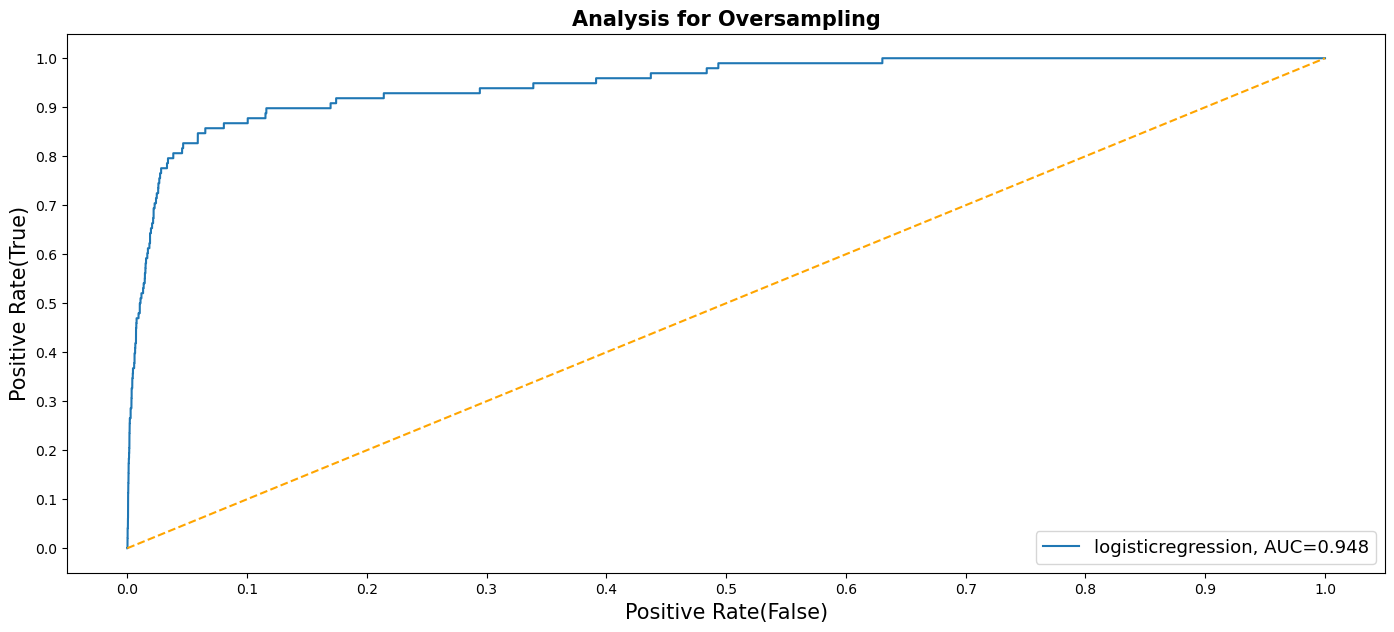

In [24]:
# Plot the ROC curve for undersampling
res_table.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(17,7))

for j in res_table.index:
    plt.plot(res_table.loc[j]['fpr'], 
             res_table.loc[j]['tpr'], 
             label="{}, AUC={:.3f}".format(j, res_table.loc[j]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Positive Rate(False)", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Positive Rate(True)", fontsize=15)
plt.title('Analysis for Oversampling', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

In [25]:
# Cumulatively create a table for the ROC curve
res_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

lin_reg_os_results = get_model_best_estimator_and_metrics(
    estimator=LogisticRegression(),
    params={"penalty": ['l1', 'l2'], 'C': [ 0.01, 0.1, 1, 100, 100], 
            'solver' : ['liblinear']},
    sampling=SMOTE(random_state=42),
    scoring="f1",
    is_grid_search=False,
    n_jobs=2,
)
print(f"==={lin_reg_os_results['estimator_name']}===")
print("Model:", lin_reg_os_results['best_estimator'])
print("Accuracy:", lin_reg_os_results['accuracy'])
print("Recall:", lin_reg_os_results['recall'])
print("F1 Score:", lin_reg_os_results['f1_score'])
res_table = res_table.append({'classifiers': lin_reg_os_results["estimator_name"],
                                        'fpr': lin_reg_os_results["fpr"], 
                                        'tpr': lin_reg_os_results["tpr"], 
                                        'auc': lin_reg_os_results["auc"]
                              }, ignore_index=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
===logisticregression===
Model: Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(C=0.01, penalty='l1', solver='liblinear'))])
Accuracy: 0.9759313226361434
Recall: 0.9183673469387755
F1 Score: 0.1160541586073501


C:\Users\brett\AppData\Local\Temp\ipykernel_10216\1743237539.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'classifiers': lin_reg_os_results["estimator_name"],


In [ ]:
#Finished copying the model format from the tutorial
#Conclusions: Understood everything until the modeling section, will do further research
#I plan to come back and replicate the outlier removal because that is a good part to practice